

![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/SENTENCE_SIMILARITY.ipynb)




# **Detect sentence similarity**

## 1. Colab Setup

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash
# !bash colab.sh
# -p is for pyspark
# -s is for spark-nlp
# !bash colab.sh -p 3.1.1 -s 3.0.1
# by default they are set to the latest

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
setup Colab for PySpark 3.1.1 and Spark NLP 3.0.0
     |████████████████████████████████| 212.3MB 76kB/s 
     |████████████████████████████████| 143kB 39.9MB/s 
     |████████████████████████████████| 204kB 50.0MB/s 


## 2. Start the Spark session

In [2]:
import json
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

spark = sparknlp.start()

## 3. Select the USE model

If you change the model, re-run the cell that creates the pipeline so the pipeline will use the new model.

In [3]:
# If you change the model, re-run all the cells below.
# Applicable models: tfhub_use, tfhub_use_lg
MODEL_NAME = "tfhub_use"
os.environ['MODEL_NAME'] = MODEL_NAME

## 4. Some sample examples

In [4]:
# To compare the similarity of sentences, enter them as strings in this list.
text_list = [
    "Sign up for our mailing list to get free offers and updates about our products!",
    "Subscribe to notifications to receive information about discounts and new offerings.",
    "Send in your information for a chance to win big in our Summer Sweepstakes!",
    "After filling out this form, you will receive a confirmation email to complete your signup.",
    "It was raining, so I waited beneath the balcony outside the cafe.",
    "I stayed under the deck of the cafe because it was rainy outside.",
    "I like the cafe down the street because it's not too loud in there.",
    "The coffee shop near where I live is quiet, so I like to go there.",
    "Web traffic analysis shows that most Internet users browse on mobile nowadays.",
    "The analytics show that modern web users mostly use their phone instead of their computers."
]

Write the input sentences into a single file.

In [5]:
! mkdir inputs
! mkdir inputs/$MODEL_NAME
with open(f'inputs/{MODEL_NAME}/sentences.txt', 'w') as input_file:
    for text in text_list:
        input_file.write(text + '\n')

## 5. Define Spark NLP pipeline

In [6]:
# Transforms the input text into a document usable by the SparkNLP pipeline.
document_assembler = DocumentAssembler()
document_assembler.setInputCol('text')
document_assembler.setOutputCol('document')

# Separates the text into individual tokens (words and punctuation).
tokenizer = Tokenizer()
tokenizer.setInputCols(['document'])
tokenizer.setOutputCol('token')

# Encodes the text as a single vector representing semantic features.
sentence_encoder = UniversalSentenceEncoder.pretrained(name=MODEL_NAME)
sentence_encoder.setInputCols(['document', 'token'])
sentence_encoder.setOutputCol('sentence_embeddings')

nlp_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer,
    sentence_encoder
])

# Fit the model to an empty data frame so it can be used on inputs.
empty_df = spark.createDataFrame([['']]).toDF('text')
pipeline_model = nlp_pipeline.fit(empty_df)
light_pipeline = LightPipeline(pipeline_model)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


## 6. Run the pipeline

This method will get the similarity of the embeddings of each pair of sentences in the list of sentences passed in. The similarity is returned as a matrix, where (0, 2), for example, represents the similarity of input sentence 0 and input sentence 2.

In [7]:
def get_similarity(input_list):
    df = spark.createDataFrame(pd.DataFrame({'text': input_list}))
    result = light_pipeline.transform(df)
    embeddings = []
    for r in result.collect():
        embeddings.append(r.sentence_embeddings[0].embeddings)
    embeddings_matrix = np.array(embeddings)
    return np.matmul(embeddings_matrix, embeddings_matrix.transpose())

Write the computed similarities to a CSV file.

In [8]:
! mkdir outputs
! mkdir outputs/$MODEL_NAME
np.savetxt(f'outputs/{MODEL_NAME}/similarities.csv',
              get_similarity(text_list),
              delimiter=',')

## 7. Visualize results

This method plots the gets the similarity of the sentences in the list using the method above, then it plots those similarities as a heatmap where dark red means "very similar" and pale yellow means "not similar at all".

In [9]:
import seaborn as sns

def plot_similarity(input_list):
    g = sns.heatmap(
        get_similarity(input_list),
        xticklabels=input_list,
        yticklabels=input_list,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(input_list, rotation=90)
    g.set_title("Semantic Textual Similarity")

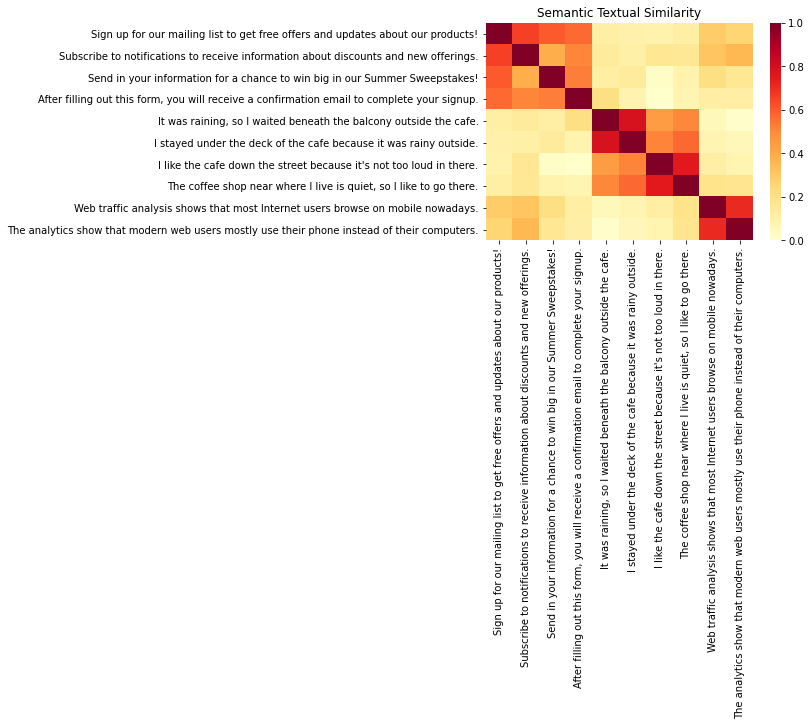

In [10]:
plot_similarity(text_list)